Data cleaning here: Upload cleaned macro to start

imports

In [1]:
##
import pandas as pd
import numpy as np
import torch



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/liang/Library/Python/3.11/lib/python/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/liang/Library/Python/3.11/lib/python/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/liang/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
 

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/liang/Library/Python/3.11/lib/python/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/liang/Library/Python/3.11/lib/python/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/liang/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
 

AttributeError: _ARRAY_API not found

 raw data cleaning here

In [2]:
def clean_date_csv(df):
    df = df.copy()  # optional: avoid modifying original
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"])
        df = df.set_index("date")
        df.index = pd.to_datetime(df.index)
    df = df.apply(pd.to_numeric, errors='coerce')
    df = df.reset_index(drop=True)
    if "date" in df.columns:
      df = df.drop(columns=["date"])
    return df

In [3]:
df = pd.read_csv('data/cleaned_macro.csv')
raw_returns = clean_date_csv(df)

creating required vol and normalized dict

In [4]:
def safe_rolling_zscore(df, window):
    rolling_mean = df.rolling(window).mean()
    rolling_std = df.rolling(window).std()

    # If std == 0 → return 0 instead of NaN or inf
    z = (df - rolling_mean) / rolling_std.replace(0, np.nan)
    z = z.fillna(0)

    return z

def generate_all_returns(raw_returns):
  normalized_returns = safe_rolling_zscore(raw_returns, window=60)
  normalized_returns_df = normalized_returns.replace([np.inf, -np.inf], 0)
  rolling_vol_df  =raw_returns.rolling(60).std() * np.sqrt(252)
  rolling_vol_df = rolling_vol_df[60:]
  raw_returns, rolling_vol_df = raw_returns.align(rolling_vol_df, join='inner')
  normalized_returns, rolling_vol_df = normalized_returns.align(rolling_vol_df, join='inner')
  return raw_returns, normalized_returns, rolling_vol_df


In [5]:
raw_returns, normalized_returns, rolling_vol_df = generate_all_returns(raw_returns)

In [6]:
print(len(raw_returns), len(normalized_returns), len(rolling_vol_df))

4099 4099 4099


creating train val test split here

In [7]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# Suppose normalized_returns, raw_returns, rolling_vol_df have same index
T = len(normalized_returns)

# ---------------------------
# Train / Val / Test Split
# ---------------------------

train_ratio = 0.8
val_ratio   = 0.16      # 20% of the total 80% train block (i.e., 16% of total)
test_ratio  = 0.20

train_end = int(T * (1 - test_ratio))         # first 80%
val_end   = int(train_end * (1 - 0.20))       # carve out 20% of train

# Alternatively:
# val_end = int(T * 0.64)   # 64% = 80% * 80%

# ---------------------------
# Slices: 0 → val → test
# ---------------------------
normalized_returns_train = normalized_returns.iloc[:val_end]
normalized_returns_val   = normalized_returns.iloc[val_end:train_end]
normalized_returns_test  = normalized_returns.iloc[train_end:]

raw_returns_train = raw_returns.iloc[:val_end]
raw_returns_val   = raw_returns.iloc[val_end:train_end]
raw_returns_test  = raw_returns.iloc[train_end:]

vol_train = rolling_vol_df.iloc[:val_end]
vol_val   = rolling_vol_df.iloc[val_end:train_end]
vol_test  = rolling_vol_df.iloc[train_end:]

print("Train:", len(normalized_returns_train))
print("Val:  ", len(normalized_returns_val))
print("Test: ", len(normalized_returns_test))


Train: 2623
Val:   656
Test:  820


Please select your augmented data here

In [ ]:

augmented_data = None
# # bootstrap
# augmented_data = pd.read_csv('data/bootstraped_macro.csv')
# augmented_data.drop(columns=['Unnamed: 0'], inplace=True)
# augmented_data = clean_date_csv(augmented_data)
# EB
# augmented_data = pd.read_csv('data/EB_sampled-1.csv')
# variational encoder
# augmented_data = pd.read_csv('data/augmented_returns_100k.csv')


In [10]:
if augmented_data is not None:
    raw_returns_train, normalized_returns_train, vol_train = generate_all_returns(augmented_data)

# neural nets

dataset builder

In [11]:
from re import X
def build_nn_data(raw_returns, normalized_returns, vol, window=20):
    """
    raw_returns:        DataFrame (T × N), unnormalized daily returns.
    normalized_returns: DataFrame (T × N), normalized version of past returns.
    vol:                DataFrame (T × N or T × K), volatility features.
    window:             Lookback window (default = 20)

    Returns:
        X:   (T-window-1, window*N)         normalized past-panel flattened
        V:   (T-window-1, vol_dim)          contemporaneous vol features
        y:   (T-window-1, N)                raw next-day returns
    """

    X_list, V_list, y_list = [], [], []

    T = len(raw_returns)
    N = raw_returns.shape[1]

    for t in range(window, T - 1):
        # ---- Feature: past normalized returns ----
        past_norm = normalized_returns.iloc[t-window:t].values.flatten()

        # ---- Vol feature for day t ----
        vol_t = vol.iloc[t].values

        # ---- Target: next-day raw return ----
        y_t1 = raw_returns.iloc[t+1].values

        X_list.append(past_norm)
        V_list.append(vol_t)
        y_list.append(y_t1)

    X = np.array(X_list, dtype=np.float32)
    V = np.array(V_list, dtype=np.float32)
    y = np.array(y_list, dtype=np.float32)

    return X, V, y

X_train, V_train, y_train = build_nn_data(raw_returns_train, normalized_returns_train, vol_train)
X_val, V_val, y_val = build_nn_data(raw_returns_val, normalized_returns_val, vol_val)
X_test, V_test, y_test = build_nn_data(raw_returns_test, normalized_returns_test, vol_test)


In [12]:
class NNDataset(Dataset):
    def __init__(self, X, vol, y):
        self.X = torch.from_numpy(X)      # (N, D)
        self.vol = torch.from_numpy(vol)  # (N, 5)
        self.y = torch.from_numpy(y)      # (N, 5)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.vol[idx], self.y[idx]

In [13]:
train_dataset = NNDataset(X_train, V_train, y_train)
val_dataset   = NNDataset(X_val,   V_val,   y_val)
test_dataset  = NNDataset(X_test,  V_test,  y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=256, shuffle=False)

model

In [14]:
class MacroPortfolioNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 6)  # 5 risky + 1 cash
        )

    def forward(self, x, vol):
        """
        x: (batch, D)        - features
        vol: (batch, 5)      - rolling vol for each asset (positive)
        Returns:
            weights: (batch, 6) - 5 risky + 1 cash
        """
        logits = self.net(x)          # (batch, 6)
        risk_scores = logits[:, :5]   # (batch, 5)
        cash_logit = logits[:, 5]     # (batch,)

        # ---- Cash weight (long-only, in [0,1]) ----
        cash_weight = torch.sigmoid(cash_logit)  # (batch,)
        risk_budget = 1.0 - cash_weight         # fraction of capital in risky assets

        # ---- Vol-normalized risky directions ----
        eps = 1e-8
        vol_adj = risk_scores / (vol + eps)     # (batch, 5)

        # Normalize so sum |weights| = 1 for the risky component
        abs_sum = torch.sum(torch.abs(vol_adj), dim=1, keepdim=True) + eps
        risk_dir = vol_adj / abs_sum            # (batch, 5), sum |risk_dir| = 1

        # Scale by risk budget
        risky_weights = risk_dir * risk_budget.unsqueeze(1)  # (batch, 5)

        # Stack with cash
        cash_weight = cash_weight.unsqueeze(1)  # (batch, 1)
        weights = torch.cat([risky_weights, cash_weight], dim=1)  # (batch, 6)
        return weights

In [15]:
def sharpe_ratio_loss(portfolio_returns, eps=1e-6):
    """
    portfolio_returns: (batch,) tensor of daily portfolio returns
    Returns: loss = -Sharpe
    """
    mean = portfolio_returns.mean()
    std = portfolio_returns.std(unbiased=False) + eps
    sharpe = (mean / std)*np.sqrt(252)
    return -sharpe


def mean_variance_loss(port_ret, risky_w, lambda_risk=16, lambda_lev=1e-3, eps=1e-8):
    """
    port_ret: (batch,) portfolio returns
    risky_w:  (batch, 5) risky weights only
    """
    mean_ret = port_ret.mean()
    var_ret  = port_ret.var(unbiased=False)

    # leverage penalty (squared L2 of risky weights)
    lev_penalty = (risky_w.pow(2).sum(dim=1)).mean()

    loss = -mean_ret + lambda_risk * var_ret
    return loss


Training loop

In [16]:
import copy
import numpy as np
import torch

input_dim = X_train.shape[1]
model = MacroPortfolioNet(input_dim=input_dim, hidden_dim=128)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
model = model.to(device)

num_epochs = 100
risk_free = 0.0

# ---- Early stopping config ----
patience = 5               # how many epochs with no improvement before stop
best_val_loss = float('inf')
best_state_dict = None
epochs_no_improve = 0

for epoch in range(num_epochs):

    # -------------------------
    # TRAIN LOOP
    # -------------------------
    model.train()
    train_losses = []

    for batch_X, batch_vol, batch_y in train_loader:
        batch_X  = batch_X.to(device)
        batch_vol = batch_vol.to(device)
        batch_y  = batch_y.to(device)

        optimizer.zero_grad()

        # Forward
        w = model(batch_X, batch_vol)    # (batch, 6)
        risky_w = w[:, :5]
        cash_w  = w[:, 5]

        risky_ret = (risky_w * batch_y).sum(dim=1)
        cash_ret  = cash_w * risk_free
        port_ret  = risky_ret + cash_ret

        # loss = sharpe_ratio_loss(port_ret)
        loss = mean_variance_loss(port_ret, risky_w)

        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    # -------------------------
    # VALIDATION LOOP
    # -------------------------
    model.eval()
    val_losses = []

    with torch.no_grad():
        for batch_X, batch_vol, batch_y in val_loader:
            batch_X  = batch_X.to(device)
            batch_vol = batch_vol.to(device)
            batch_y  = batch_y.to(device)

            w = model(batch_X, batch_vol)
            risky_w = w[:, :5]
            cash_w  = w[:, 5]

            risky_ret = (risky_w * batch_y).sum(dim=1)
            cash_ret  = cash_w * risk_free
            port_ret  = risky_ret + cash_ret

            # val_loss = sharpe_ratio_loss(port_ret)
            val_loss = mean_variance_loss(port_ret, risky_w)
            val_losses.append(val_loss.item())

    mean_train_loss = float(np.mean(train_losses))
    mean_val_loss   = float(np.mean(val_losses))

    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {mean_train_loss:.6f} | "
        f"Val Loss: {mean_val_loss:.6f}"
    )

    # -------------------------
    # EARLY STOPPING CHECK
    # -------------------------
    mean_val_loss = np.mean(val_losses)
    if mean_val_loss < best_val_loss - 1e-8:  # small tolerance
        best_val_loss = mean_val_loss
        best_state_dict = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
        # print(f"  -> New best val loss, saving model (epoch {epoch+1})")
    else:
        epochs_no_improve += 1
        # print(f"  -> No improvement for {epochs_no_improve} epoch(s).")
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best val loss: {best_val_loss:.6f}")
            break

# Restore best model weights
if best_state_dict is not None:
    model.load_state_dict(best_state_dict)
    print("Loaded best model state (early-stopping).")




Epoch 1/100 | Train Loss: 0.000010 | Val Loss: -0.000087
Epoch 2/100 | Train Loss: -0.000265 | Val Loss: 0.000015
Epoch 3/100 | Train Loss: -0.000997 | Val Loss: 0.000490
Epoch 4/100 | Train Loss: -0.002171 | Val Loss: 0.000727
Epoch 5/100 | Train Loss: -0.003063 | Val Loss: 0.001174
Epoch 6/100 | Train Loss: -0.004333 | Val Loss: 0.001700
Early stopping at epoch 6. Best val loss: -0.000087
Loaded best model state (early-stopping).


In [17]:
model.eval()
model.to("cpu")
test_returns = []
test_weights = []      # <-- NEW: store weights for each test row

with torch.no_grad():
    for batch_X, batch_vol, batch_y in test_loader:
        # Get weights
        w = model(batch_X, batch_vol)   # (batch, 6)

        risky_w = w[:, :5]              # (batch, 5)
        cash_w  = w[:, 5]               # (batch,)

        # Store weights (detach to numpy)
        test_weights.append(w.cpu().numpy())

        # Compute portfolio returns
        risky_ret = (risky_w * batch_y).sum(dim=1)
        cash_ret  = cash_w * 0.0        # risk-free = 0 for now
        port_ret  = risky_ret + cash_ret

        test_returns.append(port_ret.cpu().numpy())

# Concatenate everything (in correct temporal order)
test_returns = np.concatenate(test_returns)    # shape (T_test,)
test_weights = np.concatenate(test_weights)    # shape (T_test, 6)

# Compute Sharpe
test_sharpe = (test_returns.mean() / test_returns.std())*np.sqrt(252)
print("Test Sharpe:", test_sharpe)

# test_weights now contains:
#   w[t] = [weight_asset1, weight_asset2, ..., weight_asset5, cash_weight]
# aligned with test_returns[t]


Test Sharpe: 0.12367925101491


In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# test_weights: shape (T_test, 6)
# test_dates:   index of length T_test

weight_cols = list(raw_returns_test.columns) + ["cash"]

df_w = pd.DataFrame(test_weights[:50], columns=weight_cols)

plt.figure(figsize=(14, 7))
for col in df_w.columns:
    plt.plot(df_w.index, df_w[col], label=col)

plt.title("Test-Period Portfolio Weights")
plt.xlabel("Date")
plt.ylabel("Weight")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/liang/Library/Python/3.11/lib/python/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/liang/Library/Python/3.11/lib/python/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/liang/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
 

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import

In [ ]:
import numpy as np
import pandas as pd

def compute_performance_metrics(returns, periods_per_year=252, risk_free=0.0):
    """
    Compute Sharpe, volatility, hit rate, and max drawdown from a return series.

    Parameters
    ----------
    returns : array-like or pd.Series
        Periodic returns (e.g., daily) as decimal (0.01 = 1%).
    periods_per_year : int, optional
        Number of periods per year (252 for daily, 12 for monthly).
    risk_free : float, optional
        Risk-free rate per period (same frequency as `returns`).

    Returns
    -------
    dict
        {
            "sharpe": float,
            "volatility": float,
            "hit_rate": float,         # in [0, 1]
            "max_drawdown": float      # as a decimal, e.g. -0.25 = -25%
        }
    """
    # Convert to pandas Series for convenience
    if not isinstance(returns, pd.Series):
        returns = pd.Series(returns).dropna()
    else:
        returns = returns.dropna()

    # Excess returns
    excess = returns - risk_free

    # Annualized Sharpe ratio
    mean_excess = excess.mean()
    std_excess = excess.std(ddof=1)
    if std_excess == 0:
        sharpe = np.nan
    else:
        sharpe = (mean_excess / std_excess) * np.sqrt(periods_per_year)

    # Annualized volatility
    volatility = returns.std(ddof=1) * np.sqrt(periods_per_year)

    # Hit rate: fraction of periods with positive return
    hit_rate = (returns > 0).mean()

    # Max drawdown
    # Build equity curve: cumulative wealth assuming starting at 1
    equity = (1 + returns).cumprod()

    # Running max of equity curve
    running_max = equity.cummax()

    # Drawdown series
    drawdown = equity / running_max - 1.0

    # Max drawdown (most negative drawdown)
    max_drawdown = drawdown.min()

    return {
        "sharpe": sharpe,
        "volatility": volatility,
        "hit_rate": hit_rate,
        "max_drawdown": max_drawdown
    }


In [ ]:
compute_performance_metrics(test_returns)

{'sharpe': np.float64(-0.17818029253160036),
 'volatility': np.float64(0.17088353698634945),
 'hit_rate': np.float64(0.4806007509386733),
 'max_drawdown': -0.33894413709640503}

# CNN based model

In [ ]:
import numpy as np

window = 20  # past days

def build_panel_data(raw_returns,normalized_returns, vol, window):
    X_list, vol_list, y_list = [], [], []

    # returns: (T_train, 5)
    for t in range(window, len(raw_returns) - 1):
        # past window of returns: (window, 5)
        past_ret = normalized_returns.iloc[t-window:t].values    # (20, 5)
        # For Conv1d: (channels, seq_len) = (5, 20)
        panel = past_ret.T.astype(np.float32)         # (5, 20)

        X_list.append(panel)
        vol_list.append(vol.iloc[t].values.astype(np.float32))      # (5,)
        y_list.append(raw_returns.iloc[t].values.astype(np.float32))  # (5,)

    X = np.stack(X_list, axis=0)          # (N, 5, 20)
    vol_arr = np.stack(vol_list, axis=0)  # (N, 5)
    y = np.stack(y_list, axis=0)          # (N, 5)
    return X, vol_arr, y

X_train, vol_train_arr, y_train = build_panel_data(raw_returns_train, normalized_returns_train, vol_train, window)
X_val, vol_val_arr, y_val = build_panel_data(raw_returns_val, normalized_returns_val, vol_val, window)
X_test,  vol_test_arr,  y_test  = build_panel_data(raw_returns_test, normalized_returns_test, vol_test,  window)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class MacroPanelDataset(Dataset):
    def __init__(self, X, vol, y):
        self.X   = torch.from_numpy(X)      # (N, 5, 20)
        self.vol = torch.from_numpy(vol)    # (N, 5)
        self.y   = torch.from_numpy(y)      # (N, 5)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.vol[idx], self.y[idx]

train_dataset = MacroPanelDataset(X_train, vol_train_arr, y_train)
val_dataset   = MacroPanelDataset(X_val,   vol_val_arr,   y_val)
test_dataset  = MacroPanelDataset(X_test,  vol_test_arr,  y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=256, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MacroCNNNet(nn.Module):
    def __init__(self, n_assets=5, seq_len=20, hidden_dim=64, conv_channels=32):
        super().__init__()
        self.n_assets = n_assets
        self.seq_len = seq_len

        # Conv1d expects (batch, channels, length)
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=n_assets, out_channels=conv_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=conv_channels, out_channels=conv_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # Global average pool over time: (batch, conv_channels)
        self.fc = nn.Sequential(
            nn.Linear(conv_channels, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_assets + 1)  # 5 risky + 1 cash
        )

    def forward(self, x, vol):
        """
        x:   (batch, 5, 20)   panel of past returns
        vol: (batch, 5)       rolling vol per asset
        """
        # CNN encoder
        z = self.conv(x)                     # (batch, conv_channels, seq_len)
        z = z.mean(dim=2)                    # global avg pool over time -> (batch, conv_channels)

        logits = self.fc(z)                  # (batch, 6)
        risk_scores = logits[:, :self.n_assets]  # (batch, 5)
        cash_logit  = logits[:, self.n_assets]   # (batch,)

        # ---- same risk allocation logic as before ----
        cash_weight = torch.sigmoid(cash_logit)  # (batch,)
        risk_budget = 1.0 - cash_weight

        eps = 1e-8
        vol_adj = risk_scores / (vol + eps)      # (batch, 5)

        abs_sum = vol_adj.abs().sum(dim=1, keepdim=True) + eps
        risk_dir = vol_adj / abs_sum             # sum |risk_dir| = 1 (per sample)

        risky_w = risk_budget.unsqueeze(1) * risk_dir  # (batch, 5)
        cash_w  = cash_weight.unsqueeze(1)             # (batch, 1)

        weights = torch.cat([risky_w, cash_w], dim=1)  # (batch, 6)
        return weights


In [ ]:
model = MacroCNNNet(n_assets=5, seq_len=20, hidden_dim=128, conv_channels=32)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

model = model.to(device)

num_epochs = 100
risk_free = 0.0

# ---- Early stopping config ----
patience = 10               # how many epochs with no improvement before stop
best_val_loss = float('inf')
best_state_dict = None
epochs_no_improve = 0

for epoch in range(num_epochs):

    # -------------------------
    # TRAIN LOOP
    # -------------------------
    model.train()
    train_losses = []

    for batch_X, batch_vol, batch_y in train_loader:

        batch_X  = batch_X.to(device)
        batch_vol = batch_vol.to(device)
        batch_y  = batch_y.to(device)

        optimizer.zero_grad()

        # Forward
        w = model(batch_X, batch_vol)    # (batch, 6)
        risky_w = w[:, :5]
        cash_w  = w[:, 5]

        risky_ret = (risky_w * batch_y).sum(dim=1)
        cash_ret  = cash_w * risk_free
        port_ret  = risky_ret + cash_ret
        # loss = sharpe_ratio_loss(port_ret)
        loss = mean_variance_loss(port_ret, risky_w)

        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    # -------------------------
    # VALIDATION LOOP
    # -------------------------
    model.eval()
    val_losses = []

    with torch.no_grad():
        for batch_X, batch_vol, batch_y in val_loader:

            batch_X  = batch_X.to(device)
            batch_vol = batch_vol.to(device)
            batch_y  = batch_y.to(device)

            w = model(batch_X, batch_vol)
            risky_w = w[:, :5]
            cash_w  = w[:, 5]

            risky_ret = (risky_w * batch_y).sum(dim=1)
            cash_ret  = cash_w * risk_free
            port_ret  = risky_ret + cash_ret

            # val_loss = sharpe_ratio_loss(port_ret)
            val_loss = mean_variance_loss(port_ret, risky_w)
            val_losses.append(val_loss.item())

    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {np.mean(train_losses):.6f} | "
        f"Val Loss: {np.mean(val_losses):.6f}"
    )


    # -------------------------
    # EARLY STOPPING CHECK
    # -------------------------
    mean_val_loss = np.mean(val_losses)
    if mean_val_loss < best_val_loss - 1e-8:  # small tolerance
        best_val_loss = mean_val_loss
        best_state_dict = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
        # print(f"  -> New best val loss, saving model (epoch {epoch+1})")
    else:
        epochs_no_improve += 1
        # print(f"  -> No improvement for {epochs_no_improve} epoch(s).")
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best val loss: {best_val_loss:.6f}")
            break

# Restore best model weights
if best_state_dict is not None:
    model.load_state_dict(best_state_dict)
    print("Loaded best model state (early-stopping).")

Epoch 1/100 | Train Loss: -0.000562 | Val Loss: 0.002990
Epoch 2/100 | Train Loss: -0.000589 | Val Loss: 0.002590
Epoch 3/100 | Train Loss: -0.000594 | Val Loss: 0.002701
Epoch 4/100 | Train Loss: -0.000594 | Val Loss: 0.002619
Epoch 5/100 | Train Loss: -0.000594 | Val Loss: 0.003021
Epoch 6/100 | Train Loss: -0.000601 | Val Loss: 0.001640
Epoch 7/100 | Train Loss: -0.000614 | Val Loss: 0.002239
Epoch 8/100 | Train Loss: -0.000622 | Val Loss: 0.003207
Epoch 9/100 | Train Loss: -0.000621 | Val Loss: 0.001165
Epoch 10/100 | Train Loss: -0.000625 | Val Loss: 0.001539
Epoch 11/100 | Train Loss: -0.000628 | Val Loss: 0.001796
Epoch 12/100 | Train Loss: -0.000631 | Val Loss: 0.003131
Epoch 13/100 | Train Loss: -0.000635 | Val Loss: 0.001286
Epoch 14/100 | Train Loss: -0.000638 | Val Loss: 0.000953
Epoch 15/100 | Train Loss: -0.000645 | Val Loss: 0.002012
Epoch 16/100 | Train Loss: -0.000645 | Val Loss: 0.001503
Epoch 17/100 | Train Loss: -0.000661 | Val Loss: 0.001296
Epoch 18/100 | Train Lo

In [ ]:
model.eval()
test_returns = []

with torch.no_grad():
    for batch_X, batch_vol, batch_y in test_loader:
        w = model(batch_X, batch_vol)
        risky_w = w[:, :5]

        port_ret = (risky_w * batch_y).sum(dim=1)
        test_returns.append(port_ret.numpy())

test_returns = np.concatenate(test_returns)
test_sharpe = (test_returns.mean() / test_returns.std())*np.sqrt(252)

print("Test Sharpe:", test_sharpe)

Test Sharpe: 0.7752631416936553


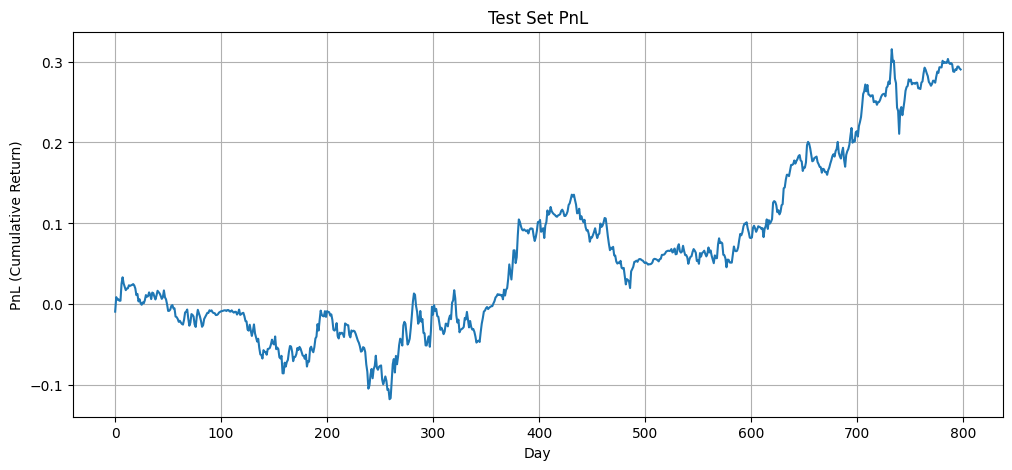

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Suppose test_returns is a 1D numpy array of daily portfolio returns
test_returns = np.array(test_returns)

# Compute cumulative PnL (starting at 0 or starting at 1, choose one)
cumulative_pnl = np.cumprod(1 + test_returns) - 1  # cumulative return
# or:
# cumulative_pnl = np.cumsum(test_returns)          # raw PnL

plt.figure(figsize=(12,5))
plt.plot(cumulative_pnl)
plt.title("Test Set PnL")
plt.xlabel("Day")
plt.ylabel("PnL (Cumulative Return)")
plt.grid(True)
plt.show()

In [ ]:
compute_performance_metrics(test_returns)

{'sharpe': np.float64(0.7747778031023946),
 'volatility': np.float64(0.11178240875542218),
 'hit_rate': np.float64(0.5168961201501877),
 'max_drawdown': -0.14572691917419434}